In [16]:
import pandas as pd
import numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder



# Define base folder for data
base_path = 'polio-measles-prediction'

# File paths (relative to the notebook)
estimates_file = f"{base_path}/IHME_GBD_2023_VACC_1980_2030_ESTIMATES_Y2025M04D25.CSV"
forecasts_file = f"{base_path}/IHME_GBD_2023_VACC_1980_2030_FORECASTS_Y2025M04D25.CSV"
measles_mv1_file = f"{base_path}/MEASLES VACCINATION 1 (MV1).xlsx"
measles_mv2_file = f"{base_path}/Measles vaccination coverage 2025-12-06 10-59 UTC (MV 2).xlsx"
polio_file = f"{base_path}/Poliomyelitis vaccination coverage 2025-12-06 11-06 UTC.xlsx"

# Load datasets with error handling
try:
    estimates_df = pd.read_csv(estimates_file)
    forecasts_df = pd.read_csv(forecasts_file)
    measles_mv1_df = pd.read_excel(measles_mv1_file)
    measles_mv2_df = pd.read_excel(measles_mv2_file)
    polio_df = pd.read_excel(polio_file)
    
    print("✅ All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ File not found: {e}")
except Exception as e:
    print(f"❌ Error loading file: {e}")


✅ All datasets loaded successfully.


In [25]:
print("🔍 ESTIMATES columns:\n", estimates_df.columns.tolist(), "\n")
print("🔍 FORECASTS columns:\n", forecasts_df.columns.tolist(), "\n")
print("🔍 MEASLES MV1 columns:\n", measles_mv1_df.columns.tolist(), "\n")
print("🔍 MEASLES MV2 columns:\n", measles_mv2_df.columns.tolist(), "\n")
print("🔍 POLIO columns:\n", polio_df.columns.tolist(), "\n")


🔍 ESTIMATES columns:
 ['measure_id', 'measure_name', 'vaccine_name', 'location_id', 'location_name', 'sex_id', 'sex_name', 'year_id', 'mean', 'lower', 'upper', 'covid_scenario'] 

🔍 FORECASTS columns:
 ['scenario', 'measure_id', 'measure_name', 'vaccine_name', 'location_id', 'location_name', 'sex_id', 'sex_name', 'year_id', 'mean', 'lower', 'upper'] 

🔍 MEASLES MV1 columns:
 ['GROUP', 'CODE', 'NAME', 'YEAR', 'ANTIGEN', 'ANTIGEN_DESCRIPTION', 'COVERAGE_CATEGORY', 'COVERAGE_CATEGORY_DESCRIPTION', 'TARGET_NUMBER', 'DOSES', 'COVERAGE'] 

🔍 MEASLES MV2 columns:
 ['GROUP', 'CODE', 'NAME', 'YEAR', 'ANTIGEN', 'ANTIGEN_DESCRIPTION', 'COVERAGE_CATEGORY', 'COVERAGE_CATEGORY_DESCRIPTION', 'TARGET_NUMBER', 'DOSES', 'COVERAGE'] 

🔍 POLIO columns:
 ['GROUP', 'CODE', 'NAME', 'YEAR', 'ANTIGEN', 'ANTIGEN_DESCRIPTION', 'COVERAGE_CATEGORY', 'COVERAGE_CATEGORY_DESCRIPTION', 'TARGET_NUMBER', 'DOSES', 'COVERAGE'] 



In [10]:
# Filter function for IHME datasets (estimates + forecasts)
def filter_ihme(df):
    return df[(df['location_name'] == 'Kenya') & (df['year_id'] >= 2010) & (df['year_id'] <= 2024)]

# Filter function for WHO Excel datasets (measles + polio)
def filter_who(df):
    return df[(df['NAME'] == 'Kenya') & (df['YEAR'] >= 2010) & (df['YEAR'] <= 2024)]

# Apply filters
kenya_estimates = filter_ihme(estimates_df)
kenya_forecasts = filter_ihme(forecasts_df)
kenya_mv1 = filter_who(measles_mv1_df)
kenya_mv2 = filter_who(measles_mv2_df)
kenya_polio = filter_who(polio_df)

# Preview 3 rows from each filtered dataset
print("🔹 Kenya ESTIMATES:\n", kenya_estimates.head(3), "\n")
print("🔹 Kenya FORECASTS:\n", kenya_forecasts.head(3), "\n")
print("🔹 Kenya MEASLES MV1:\n", kenya_mv1.head(3), "\n")
print("🔹 Kenya MEASLES MV2:\n", kenya_mv2.head(3), "\n")
print("🔹 Kenya POLIO:\n", kenya_polio.head(3), "\n")


🔹 Kenya ESTIMATES:
        measure_id measure_name vaccine_name  location_id location_name  \
72630          18   Proportion          BCG          180         Kenya   
72631          18   Proportion          BCG          180         Kenya   
72632          18   Proportion          BCG          180         Kenya   

       sex_id sex_name  year_id   mean  lower  upper   covid_scenario  
72630       3     Both     2010  0.964  0.952  0.974  covid_inclusive  
72631       3     Both     2011  0.963  0.950  0.972  covid_inclusive  
72632       3     Both     2012  0.890  0.854  0.918  covid_inclusive   

🔹 Kenya FORECASTS:
        scenario  measure_id measure_name vaccine_name  location_id  \
9450      worse          18   Proportion         DTP3          180   
9451  reference          18   Proportion         DTP3          180   
9452     better          18   Proportion         DTP3          180   

     location_name  sex_id sex_name  year_id   mean  lower  upper  
9450         Kenya      

In [11]:
# ✅ Step 2: Combine MV1, MV2, and Polio datasets for Kenya
kenya_combined = pd.concat([kenya_mv1, kenya_mv2, kenya_polio], ignore_index=True)

# Keep only the relevant columns for modeling
kenya_combined = kenya_combined[['YEAR', 'COVERAGE', 'ANTIGEN']]

# Drop missing data if any
kenya_combined = kenya_combined.dropna(subset=['YEAR', 'COVERAGE'])

# Display sample of combined dataset
kenya_combined.head()


,YEAR,COVERAGE,ANTIGEN
0,2024.0,81.55,MCV1
1,2024.0,82.00,MCV1
2,2023.0,85.33,MCV1
3,2023.0,85.00,MCV1
4,2023.0,91.00,MCV1


In [12]:
# ✅ Step 3: Train a regression model to predict coverage

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# One-hot encode 'ANTIGEN' column
encoder = OneHotEncoder(sparse_output=False)
antigen_encoded = encoder.fit_transform(kenya_combined[['ANTIGEN']])
antigen_encoded_df = pd.DataFrame(antigen_encoded, columns=encoder.get_feature_names_out(['ANTIGEN']))

# Combine with YEAR
X = pd.concat([kenya_combined[['YEAR']].reset_index(drop=True), antigen_encoded_df], axis=1)
y = kenya_combined['COVERAGE'].reset_index(drop=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ Model trained successfully!")
print(f"📉 Mean Absolute Error: {mae:.2f}")
print(f"📈 R² Score: {r2:.2f}")


✅ Model trained successfully!
📉 Mean Absolute Error: 7.14
📈 R² Score: 0.78


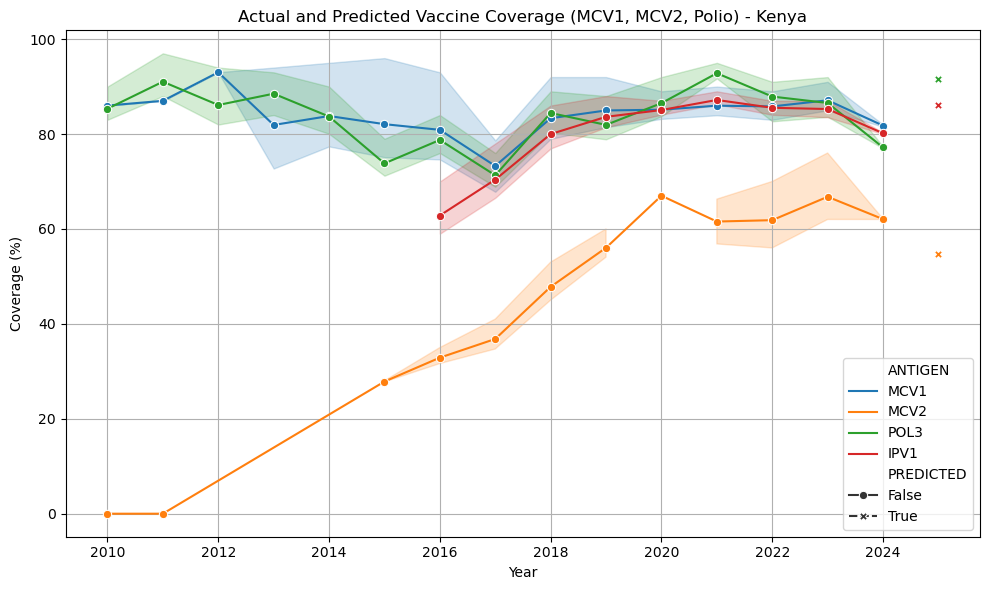

In [17]:
# STEP 4: Predict coverage for 2025 by antigen
future_year = 2025
future_antigens = encoder.get_feature_names_out(['ANTIGEN'])

# Create a new DataFrame for 2025 with each antigen
future_data = pd.DataFrame({
    'YEAR': [future_year] * len(future_antigens),
})
future_antigen_df = pd.DataFrame(
    np.identity(len(future_antigens)), columns=future_antigens
)

future_2025 = pd.concat([future_data.reset_index(drop=True), future_antigen_df.reset_index(drop=True)], axis=1)

# Make predictions
future_predictions = model.predict(future_2025)

# Prepare for plotting
future_df = pd.DataFrame({
    'YEAR': [2025] * len(future_antigens),
    'PREDICTED_COVERAGE': future_predictions,
    'ANTIGEN': [name.split('_')[1] for name in future_antigens]
})

# Combine with original data for plotting
combined_plot_data = kenya_combined.copy()
combined_plot_data['PREDICTED'] = False
future_df['PREDICTED'] = True
future_df = future_df.rename(columns={'PREDICTED_COVERAGE': 'COVERAGE'})

final_plot_data = pd.concat([combined_plot_data[['YEAR', 'COVERAGE', 'ANTIGEN', 'PREDICTED']], future_df], ignore_index=True)

# Plot actual and predicted coverage
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_plot_data, x='YEAR', y='COVERAGE', hue='ANTIGEN', style='PREDICTED', markers=True)
plt.title('Actual and Predicted Vaccine Coverage (MCV1, MCV2, Polio) - Kenya')
plt.ylabel('Coverage (%)')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --- SUMMARY FOR IHME ESTIMATES ---
print("📊 ESTIMATES: Summary Statistics")
print(kenya_estimates[['vaccine_name', 'year_id', 'sex_name', 'mean', 'lower', 'upper']].describe(include='all'))

# --- GENDER DISTRIBUTION ESTIMATES ---
print("\n👥 ESTIMATES: Gender Distribution")
print(kenya_estimates['sex_name'].value_counts())

# --- SUMMARY FOR FORECASTS ---
print("\n📊 FORECASTS: Summary Statistics")
print(kenya_forecasts[['vaccine_name', 'year_id', 'sex_name', 'mean', 'lower', 'upper']].describe(include='all'))

# --- GENDER DISTRIBUTION FORECASTS ---
print("\n👥 FORECASTS: Gender Distribution")
print(kenya_forecasts['sex_name'].value_counts())

# --- SUMMARY FOR WHO DATASETS (MV1, MV2, POLIO) ---
def summarize_who(df, name):
    print(f"\n📊 {name}: Vaccine Summary (DOSES and COVERAGE)")
    print(df[['ANTIGEN', 'YEAR', 'DOSES', 'COVERAGE']].groupby(['ANTIGEN', 'YEAR']).agg(['mean', 'std', 'sum', 'min', 'max']))

summarize_who(kenya_mv1, "Measles MV1")
summarize_who(kenya_mv2, "Measles MV2")
summarize_who(kenya_polio, "Polio")

# --- TOTAL DOSES PER VACCINE ---
def total_doses(df, name):
    print(f"\n💉 {name}: Total Doses by Vaccine")
    print(df.groupby('ANTIGEN')['DOSES'].sum())

total_doses(kenya_mv1, "MV1")
total_doses(kenya_mv2, "MV2")
total_doses(kenya_polio, "Polio")


import matplotlib.pyplot as plt
import seaborn as sns

# Ensure year is sorted for proper trend lines
kenya_estimates_sorted = kenya_estimates.sort_values(by='year_id')
kenya_forecasts_sorted = kenya_forecasts.sort_values(by='year_id')

# --- PLOT 1: IHME Estimates Coverage Trend by Vaccine ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=kenya_estimates_sorted, x='year_id', y='mean', hue='vaccine_name', marker="o")
plt.title('📈 IHME Estimated Vaccine Coverage in Kenya (2010–2024)')
plt.xlabel('Year')
plt.ylabel('Mean Coverage')
plt.grid(True)
plt.legend(title='Vaccine')
plt.tight_layout()
plt.show()

# --- PLOT 2: WHO MV1, MV2, Polio Coverage Over Time ---
def plot_who_coverage(df, title):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='YEAR', y='COVERAGE', hue='ANTIGEN', marker='o')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Coverage (%)')
    plt.grid(True)
    plt.legend(title='Vaccine')
    plt.tight_layout()
    plt.show()

plot_who_coverage(kenya_mv1, "📊 Measles MV1 Coverage in Kenya (2010–2024)")
plot_who_coverage(kenya_mv2, "📊 Measles MV2 Coverage in Kenya (2010–2024)")
plot_who_coverage(kenya_polio, "📊 Polio Coverage in Kenya (2010–2024)")


In [ ]:
print("🔍 ESTIMATES columns:\n", estimates_df.columns.tolist(), "\n")
print("🔍 FORECASTS columns:\n", forecasts_df.columns.tolist(), "\n")
print("🔍 MEASLES MV1 columns:\n", measles_mv1_df.columns.tolist(), "\n")
print("🔍 MEASLES MV2 columns:\n", measles_mv2_df.columns.tolist(), "\n")
print("🔍 POLIO columns:\n", polio_df.columns.tolist(), "\n")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure year is sorted for proper trend lines
kenya_estimates_sorted = kenya_estimates.sort_values(by='year_id')
kenya_forecasts_sorted = kenya_forecasts.sort_values(by='year_id')

# --- PLOT 1: IHME Estimates Coverage Trend by Vaccine ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=kenya_estimates_sorted, x='year_id', y='mean', hue='vaccine_name', marker="o")
plt.title('IHME Estimated Vaccine Coverage in Kenya (2010–2024)')
plt.xlabel('Year')
plt.ylabel('Mean Coverage')
plt.grid(True)
plt.legend(title='Vaccine')
plt.tight_layout()
plt.show()

# --- PLOT 2: WHO MV1, MV2, Polio Coverage Over Time ---
def plot_who_coverage(df, title):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='YEAR', y='COVERAGE', hue='ANTIGEN', marker='o')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Coverage (%)')
    plt.grid(True)
    plt.legend(title='Vaccine')
    plt.tight_layout()
    plt.show()

plot_who_coverage(kenya_mv1, " Measles MV1 Coverage in Kenya (2010–2024)")
plot_who_coverage(kenya_mv2, "Measles MV2 Coverage in Kenya (2010–2024)")
plot_who_coverage(kenya_polio, "Polio Coverage in Kenya (2010–2024)")


In [44]:
# Ensure kenya_mv1 is defined
kenya_mv1 = measles_mv1_df[measles_mv1_df['NAME'].str.contains("Kenya", case=False, na=False)]
kenya_mv1 = kenya_mv1.dropna(subset=['YEAR', 'DOSES'])
kenya_mv1 = kenya_mv1.sort_values("YEAR")


In [46]:
# Assuming you already loaded this earlier:
# estimates_df = pd.read_csv(estimates_file)
# forecasts_df = pd.read_csv(forecasts_file)

# Filter for Kenya
kenya_estimates = estimates_df[estimates_df['location_name'].str.lower() == "kenya"]
kenya_forecasts = forecasts_df[forecasts_df['location_name'].str.lower() == "kenya"]


In [47]:
# A. List unique vaccine types from IHME estimates + forecasts
unique_estimates_vaccines = kenya_estimates['vaccine_name'].unique()
unique_forecasts_vaccines = kenya_forecasts['vaccine_name'].unique()

print("Unique Vaccines in Estimates Data:")
print(unique_estimates_vaccines)

print("\nUnique Vaccines in Forecasts Data:")
print(unique_forecasts_vaccines)

# B. Count of vaccine types
vaccine_counts_estimates = kenya_estimates['vaccine_name'].value_counts()
vaccine_counts_forecasts = kenya_forecasts['vaccine_name'].value_counts()

# C. Plotting logic (as you already wrote)


Unique Vaccines in Estimates Data:
['BCG' 'DTP1' 'DTP3' 'HepB3' 'Hib3' 'MCV1' 'MCV2' 'PCV3' 'Polio3' 'RCV1'
 'RotaC']

Unique Vaccines in Forecasts Data:
['DTP3' 'MCV2' 'PCV3']


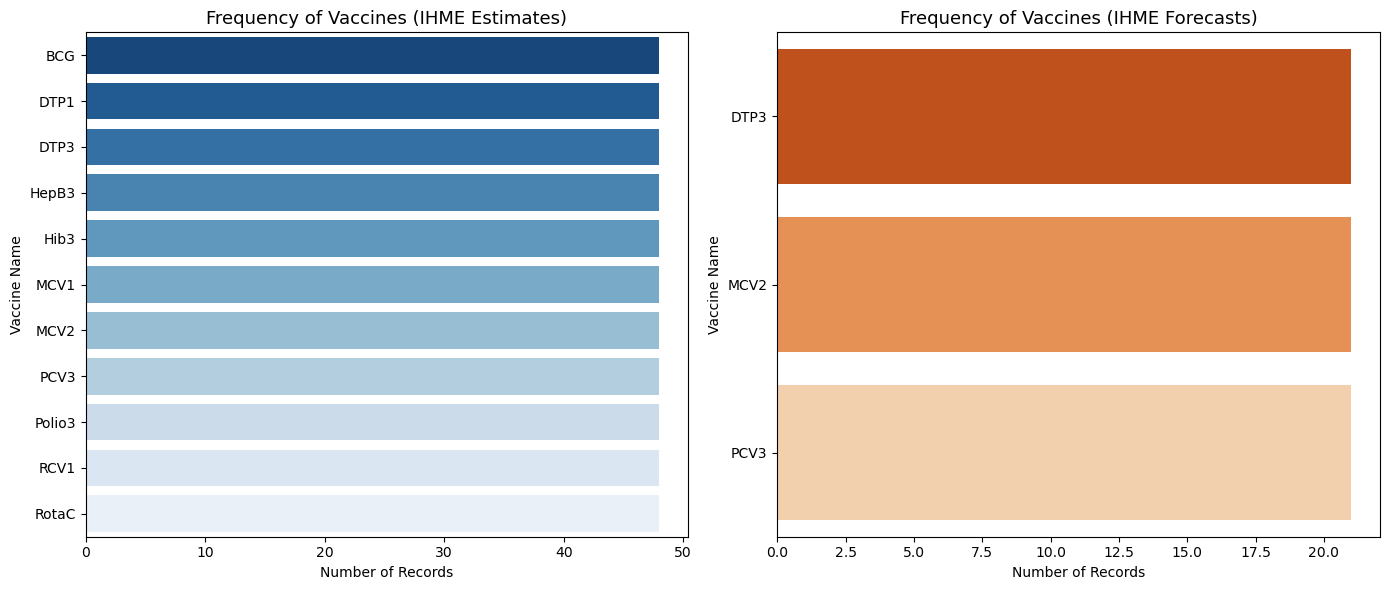

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure kenya_estimates and kenya_forecasts are defined beforehand

# Count of vaccine records
vaccine_counts_estimates = kenya_estimates['vaccine_name'].value_counts()
vaccine_counts_forecasts = kenya_forecasts['vaccine_name'].value_counts()

# Plotting the bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Estimates Bar Chart
sns.barplot(
    x=vaccine_counts_estimates.values,
    y=vaccine_counts_estimates.index,
    hue=vaccine_counts_estimates.index,  # explicitly set hue
    palette="Blues_r",
    ax=axes[0],
    legend=False
)
axes[0].set_title('Frequency of Vaccines (IHME Estimates)', fontsize=13)
axes[0].set_xlabel('Number of Records')
axes[0].set_ylabel('Vaccine Name')

# Forecasts Bar Chart
sns.barplot(
    x=vaccine_counts_forecasts.values,
    y=vaccine_counts_forecasts.index,
    hue=vaccine_counts_forecasts.index,
    palette="Oranges_r",
    ax=axes[1],
    legend=False
)
axes[1].set_title('Frequency of Vaccines (IHME Forecasts)', fontsize=13)
axes[1].set_xlabel('Number of Records')
axes[1].set_ylabel('Vaccine Name')

plt.tight_layout()
plt.show()


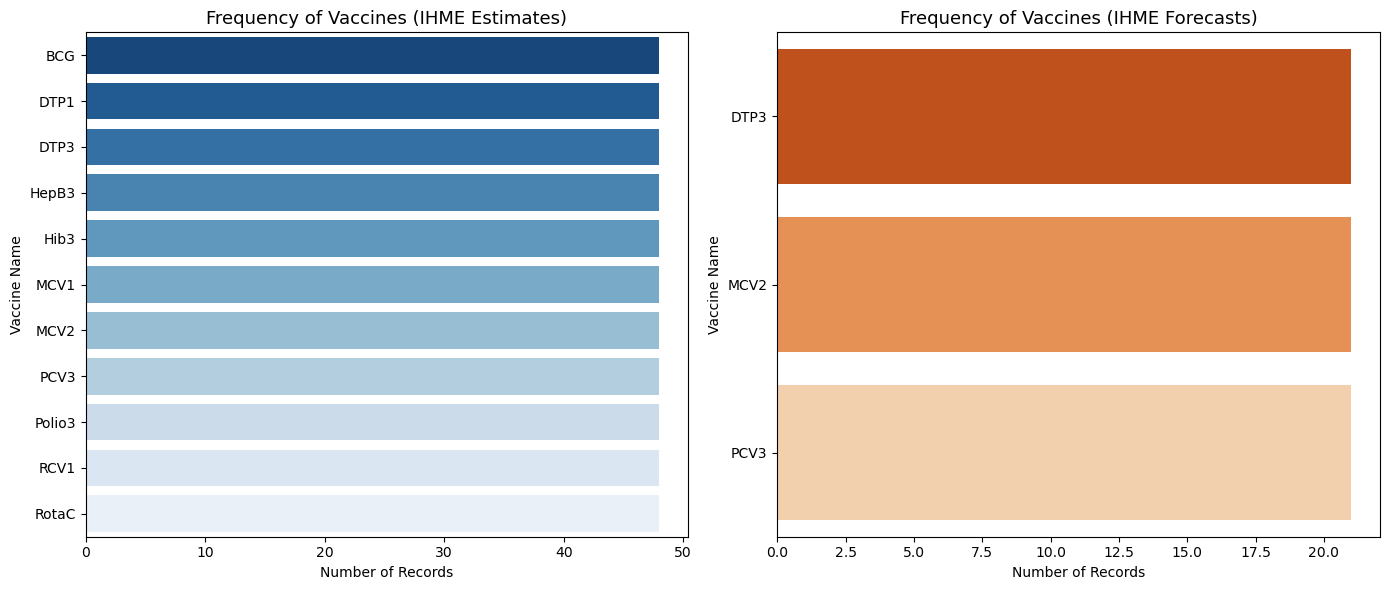

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load your datasets
estimates_file = 'polio-measles-prediction/IHME_GBD_2023_VACC_1980_2030_ESTIMATES_Y2025M04D25.CSV'
forecasts_file = 'polio-measles-prediction/IHME_GBD_2023_VACC_1980_2030_FORECASTS_Y2025M04D25.CSV'

estimates_df = pd.read_csv(estimates_file)
forecasts_df = pd.read_csv(forecasts_file)

# Step 2: Filter for Kenya only
kenya_estimates = estimates_df[estimates_df['location_name'] == 'Kenya']
kenya_forecasts = forecasts_df[forecasts_df['location_name'] == 'Kenya']

# Step 3: Count of vaccine types
vaccine_counts_estimates = kenya_estimates['vaccine_name'].value_counts()
vaccine_counts_forecasts = kenya_forecasts['vaccine_name'].value_counts()

# Step 4: Plotting the bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Estimates Bar Chart
sns.barplot(
    x=vaccine_counts_estimates.values,
    y=vaccine_counts_estimates.index,
    hue=vaccine_counts_estimates.index,  # fix deprecation warning
    palette="Blues_r",
    ax=axes[0],
    legend=False
)
axes[0].set_title('Frequency of Vaccines (IHME Estimates)', fontsize=13)
axes[0].set_xlabel('Number of Records')
axes[0].set_ylabel('Vaccine Name')

# Forecasts Bar Chart
sns.barplot(
    x=vaccine_counts_forecasts.values,
    y=vaccine_counts_forecasts.index,
    hue=vaccine_counts_forecasts.index,
    palette="Oranges_r",
    ax=axes[1],
    legend=False
)
axes[1].set_title('Frequency of Vaccines (IHME Forecasts)', fontsize=13)
axes[1].set_xlabel('Number of Records')
axes[1].set_ylabel('Vaccine Name')

plt.tight_layout()
plt.show()


In [28]:
# Filter Measles MV1 for Kenya between 2010 and 2024
measles_mv1_kenya = measles_mv1_df[
    (measles_mv1_df['NAME'] == 'Kenya') &
    (measles_mv1_df['YEAR'].between(2010, 2024))
].copy()

# Ensure YEAR is treated as integer
measles_mv1_kenya['YEAR'] = measles_mv1_kenya['YEAR'].astype(int)

# View a sample
print(measles_mv1_kenya[['YEAR', 'ANTIGEN', 'DOSES', 'COVERAGE']].head())


   YEAR ANTIGEN      DOSES  COVERAGE
0  2024    MCV1  1333972.0     81.55
1  2024    MCV1        NaN     82.00
2  2023    MCV1  1366434.0     85.33
3  2023    MCV1        NaN     85.00
7  2023    MCV1        NaN     91.00


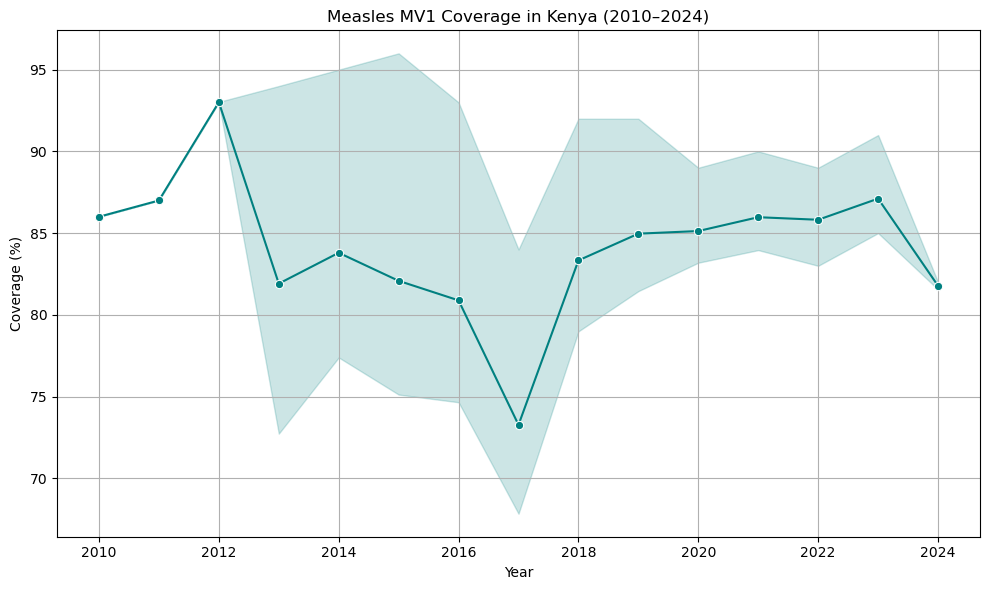

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=measles_mv1_kenya, x='YEAR', y='COVERAGE', marker='o', color='teal')
plt.title('Measles MV1 Coverage in Kenya (2010–2024)')
plt.xlabel('Year')
plt.ylabel('Coverage (%)')
plt.grid(True)
plt.tight_layout()
plt.show()




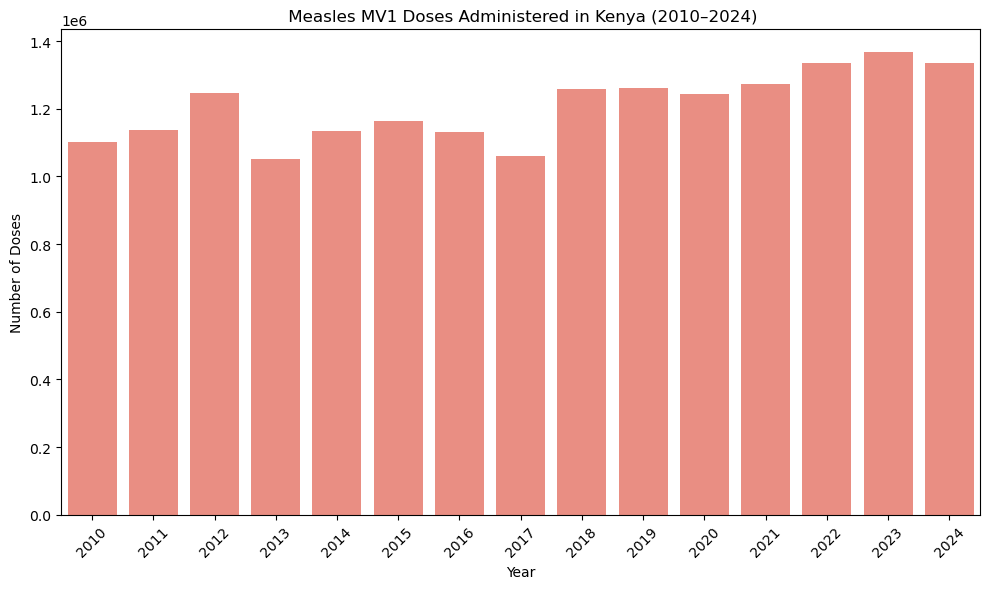

In [55]:
plt.figure(figsize=(10, 6))
sns.barplot(data=measles_mv1_kenya, x='YEAR', y='DOSES', color='salmon')
plt.title(' Measles MV1 Doses Administered in Kenya (2010–2024)')
plt.xlabel('Year')
plt.ylabel('Number of Doses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


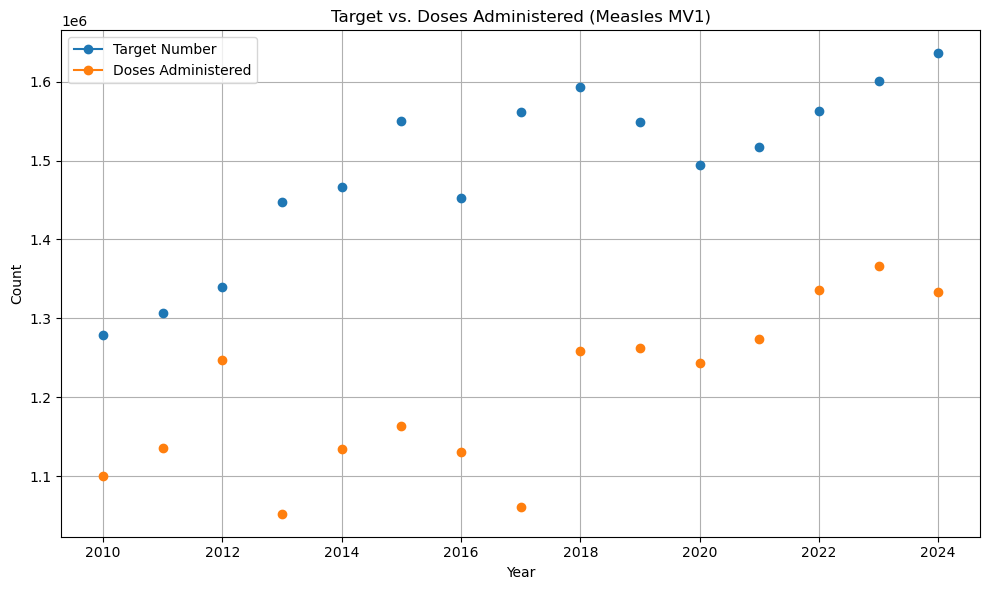

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(measles_mv1_kenya['YEAR'], measles_mv1_kenya['TARGET_NUMBER'], label='Target Number', marker='o')
plt.plot(measles_mv1_kenya['YEAR'], measles_mv1_kenya['DOSES'], label='Doses Administered', marker='o')
plt.title('Target vs. Doses Administered (Measles MV1)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
summary_stats = measles_mv1_kenya[['DOSES', 'COVERAGE', 'TARGET_NUMBER']].describe()
print("📊 Summary Statistics for Measles MV1 in Kenya (2010–2024):\n")
print(summary_stats)


📊 Summary Statistics for Measles MV1 in Kenya (2010–2024):

              DOSES   COVERAGE  TARGET_NUMBER
count  1.500000e+01  44.000000   1.500000e+01
mean   1.206727e+06  84.189773   1.490404e+06
std    1.020017e+05   7.047112   1.093516e+05
min    1.052420e+06  67.830000   1.278594e+06
25%    1.132817e+06  79.000000   1.449848e+06
50%    1.243443e+06  84.500000   1.517680e+06
75%    1.268105e+06  89.250000   1.562052e+06
max    1.366434e+06  96.000000   1.635810e+06


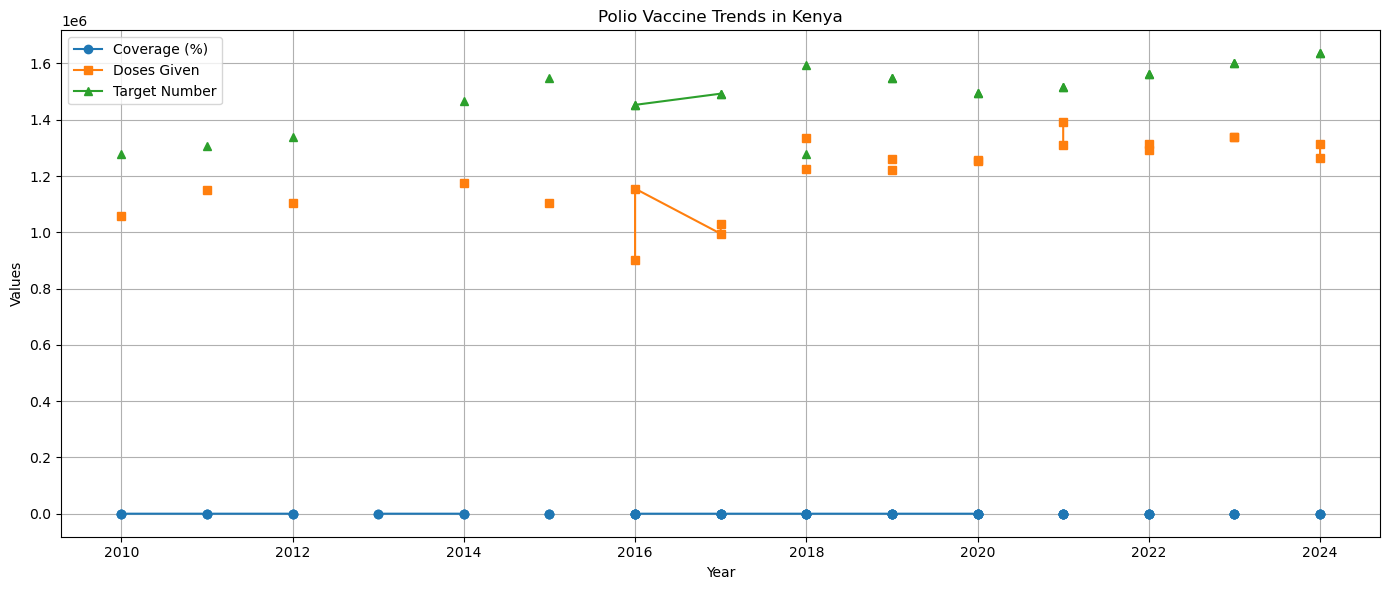

In [32]:
# If polio_df already contains only polio-related antigens:
# Optionally filter specific antigen if needed
# polio_df = polio_df[polio_df["ANTIGEN"] == "POL3"]

polio_df_sorted = polio_df.sort_values("YEAR")

plt.figure(figsize=(14, 6))

plt.plot(polio_df_sorted["YEAR"], polio_df_sorted["COVERAGE"], marker="o", label="Coverage (%)")
plt.plot(polio_df_sorted["YEAR"], polio_df_sorted["DOSES"], marker="s", label="Doses Given")
plt.plot(polio_df_sorted["YEAR"], polio_df_sorted["TARGET_NUMBER"], marker="^", label="Target Number")

plt.title("Polio Vaccine Trends in Kenya")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd

# Load the Polio dataset
polio_df = pd.read_excel("polio-measles-prediction/Poliomyelitis vaccination coverage 2025-12-06 11-06 UTC.xlsx")

# Optional: View the first few rows
polio_df.head()


,GROUP,CODE,NAME,YEAR,ANTIGEN,ANTIGEN_DESCRIPTION,COVERAGE_CATEGORY,COVERAGE_CATEGORY_DESCRIPTION,TARGET_NUMBER,DOSES,COVERAGE
0,COUNTRIES,KEN,Kenya,2024.0,IPV2_FRAC,Fractional inactivated polio-containing vaccin...,ADMIN,Administrative coverage,NaN,NaN,NaN
1,COUNTRIES,KEN,Kenya,2024.0,IPV2,"Inactivated polio-containing vaccine, 2nd dose",ADMIN,Administrative coverage,NaN,NaN,NaN
2,COUNTRIES,KEN,Kenya,2024.0,IPV1_FRAC,Fractional inactivated polio-containing vaccin...,ADMIN,Administrative coverage,NaN,NaN,NaN
3,COUNTRIES,KEN,Kenya,2024.0,POL3,"Polio, 3rd dose",ADMIN,Administrative coverage,1635810.0,1265137.0,77.34
4,COUNTRIES,KEN,Kenya,2024.0,IPV1,"Inactivated polio-containing vaccine, 1st dose",ADMIN,Administrative coverage,1635810.0,1313764.0,80.31


In [33]:
# Filter for Polio-related antigen rows
polio_data = polio_df[polio_df['ANTIGEN'].str.contains("Polio", case=False, na=False)]


In [53]:
# Print initial shape
print("🔎 Full Polio Dataset Shape:", polio_df.shape)

# Print available columns
print("📋 Columns:", polio_df.columns.tolist())

# Check for presence of key columns
required_cols = ['ANTIGEN', 'YEAR', 'COVERAGE', 'DOSES', 'TARGET_NUMBER']
missing_cols = [col for col in required_cols if col not in polio_df.columns]
if missing_cols:
    print(f"❌ Missing columns: {missing_cols}")
else:
    print("✅ All required columns are present.")

# Filter for 'Polio' antigen
polio_data = polio_df[polio_df['ANTIGEN'].str.contains("Polio", case=False, na=False)]
print("🔬 Polio Filtered Rows:", len(polio_data))

# Show sample of filtered data
print(polio_data[['YEAR', 'ANTIGEN', 'COVERAGE', 'DOSES', 'TARGET_NUMBER']].head(10))

# Check for NaNs
print("🧼 Null values in filtered data:")
print(polio_data.isna().sum())


🔎 Full Polio Dataset Shape: (115, 11)
📋 Columns: ['GROUP', 'CODE', 'NAME', 'YEAR', 'ANTIGEN', 'ANTIGEN_DESCRIPTION', 'COVERAGE_CATEGORY', 'COVERAGE_CATEGORY_DESCRIPTION', 'TARGET_NUMBER', 'DOSES', 'COVERAGE']
✅ All required columns are present.
🔬 Polio Filtered Rows: 0
Empty DataFrame
Columns: [YEAR, ANTIGEN, COVERAGE, DOSES, TARGET_NUMBER]
Index: []
🧼 Null values in filtered data:
GROUP                            0
CODE                             0
NAME                             0
YEAR                             0
ANTIGEN                          0
ANTIGEN_DESCRIPTION              0
COVERAGE_CATEGORY                0
COVERAGE_CATEGORY_DESCRIPTION    0
TARGET_NUMBER                    0
DOSES                            0
COVERAGE                         0
dtype: int64


In [35]:
print("🧪 Unique values in ANTIGEN column:")
print(polio_df['ANTIGEN'].unique())


🧪 Unique values in ANTIGEN column:
['IPV2_FRAC' 'IPV2' 'IPV1_FRAC' 'POL3' 'IPV1' nan]


In [9]:
polio_df['ANTIGEN'].unique()


array(['IPV2_FRAC', 'IPV2', 'IPV1_FRAC', 'POL3', 'IPV1', nan],
      dtype=object)

 ANTIGEN values: ['IPV2_FRAC' 'IPV2' 'IPV1_FRAC' 'POL3' 'IPV1' nan]


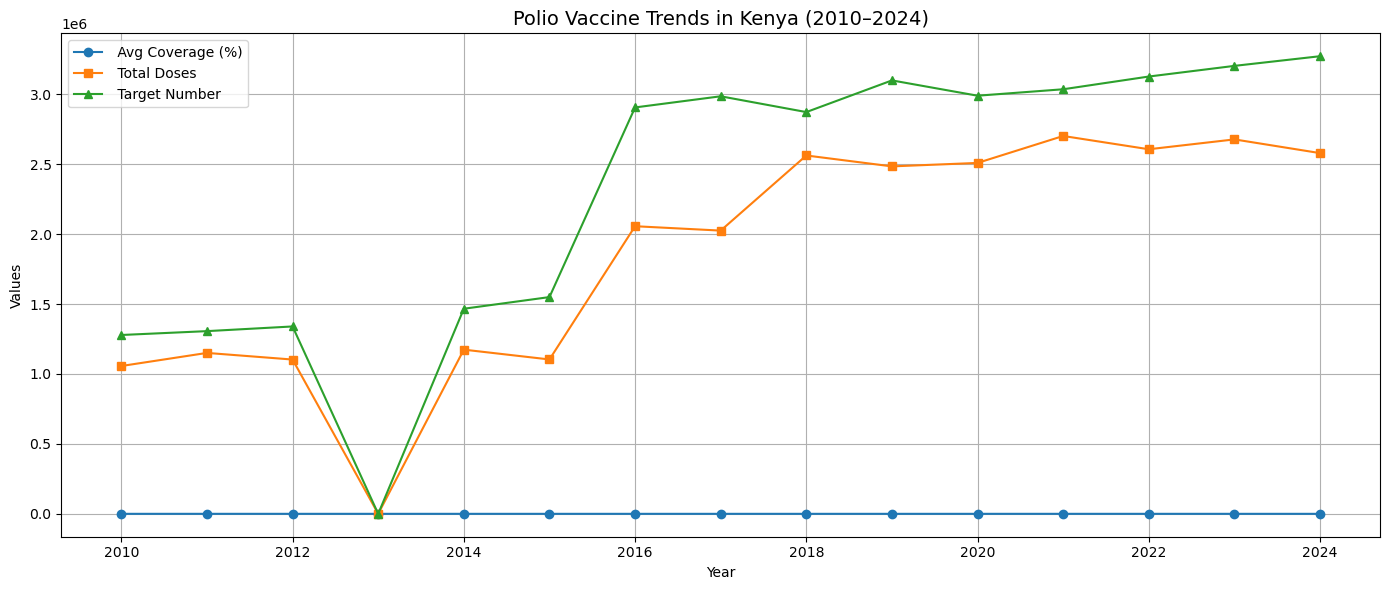

🔍 Unique ANTIGEN values: ['MCV2' nan]
🔍 Unique ANTIGEN values: ['MCV2' nan]


In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Polio data
polio_df = pd.read_excel("polio-measles-prediction/Poliomyelitis vaccination coverage 2025-12-06 11-06 UTC.xlsx")

# Show ANTIGEN values
print(" ANTIGEN values:", polio_df['ANTIGEN'].unique())

# Filter for known polio-related antigens
polio_antigens = ['POL3', 'IPV1', 'IPV2', 'IPV1_FRAC', 'IPV2_FRAC']
polio_data = polio_df[polio_df['ANTIGEN'].isin(polio_antigens)]

# Drop rows with missing YEAR or COVERAGE
polio_data = polio_data.dropna(subset=['YEAR', 'COVERAGE'])

# Group by year and summarize
polio_grouped = polio_data.groupby('YEAR').agg({
    'COVERAGE': 'mean',
    'DOSES': 'sum',
    'TARGET_NUMBER': 'sum'
}).reset_index()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(polio_grouped['YEAR'], polio_grouped['COVERAGE'], marker='o', label=' Avg Coverage (%)')
plt.plot(polio_grouped['YEAR'], polio_grouped['DOSES'], marker='s', label=' Total Doses')
plt.plot(polio_grouped['YEAR'], polio_grouped['TARGET_NUMBER'], marker='^', label=' Target Number')

plt.title("Polio Vaccine Trends in Kenya (2010–2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


import pandas as pd

# Load the MV2 Excel file
measles_mv2_df = pd.read_excel("polio-measles-prediction/Measles vaccination coverage 2025-12-06 10-59 UTC (MV 2).xlsx")

# Preview the ANTIGEN column to confirm what values are present
print("🔍 Unique ANTIGEN values:", measles_mv2_df["ANTIGEN"].unique())


import pandas as pd

# Load the MV2 Excel file
measles_mv2_df = pd.read_excel("polio-measles-prediction/Measles vaccination coverage 2025-12-06 10-59 UTC (MV 2).xlsx")

# Preview the ANTIGEN column to confirm what values are present
print("🔍 Unique ANTIGEN values:", measles_mv2_df["ANTIGEN"].unique())


In [38]:
import pandas as pd

# Load the MV2 Excel file
measles_mv2_df = pd.read_excel("polio-measles-prediction/Measles vaccination coverage 2025-12-06 10-59 UTC (MV 2).xlsx")

# Preview the ANTIGEN column to confirm what values are present
print("🔍 Unique ANTIGEN values:", measles_mv2_df["ANTIGEN"].unique())


🔍 Unique ANTIGEN values: ['MCV2' nan]


In [18]:
# Filter rows where ANTIGEN is 'MCV2' (Measles Second Dose)
mv2_df = measles_mv2_df[measles_mv2_df["ANTIGEN"] == "MCV2"].sort_values("YEAR")

# Preview to confirm filtering worked
print("✅ Filtered MV2 Data:", mv2_df.shape)
mv2_df.head()


✅ Filtered MV2 Data: (128, 11)


,GROUP,CODE,NAME,YEAR,ANTIGEN,ANTIGEN_DESCRIPTION,COVERAGE_CATEGORY,COVERAGE_CATEGORY_DESCRIPTION,TARGET_NUMBER,DOSES,COVERAGE
127,WHO_REGIONS,WPR,Western Pacific Region,2010.0,MCV2,"Measles-containing vaccine, 2nd dose",WUENIC,WHO/UNICEF Estimates of National Immunization ...,24276890.0,20999538.0,87.0
119,COUNTRIES,KEN,Kenya,2010.0,MCV2,"Measles-containing vaccine, 2nd dose",ADMIN,Administrative coverage,0.0,0.0,0.0
120,COUNTRIES,KEN,Kenya,2010.0,MCV2,"Measles-containing vaccine, 2nd dose",OFFICIAL,Official coverage,NaN,NaN,NaN
121,WHO_REGIONS,AFR,African Region,2010.0,MCV2,"Measles-containing vaccine, 2nd dose",WUENIC,WHO/UNICEF Estimates of National Immunization ...,29172350.0,1308200.0,4.0
126,WHO_REGIONS,SEAR,South-East Asia Region,2010.0,MCV2,"Measles-containing vaccine, 2nd dose",WUENIC,WHO/UNICEF Estimates of National Immunization ...,36628713.0,5430731.0,15.0


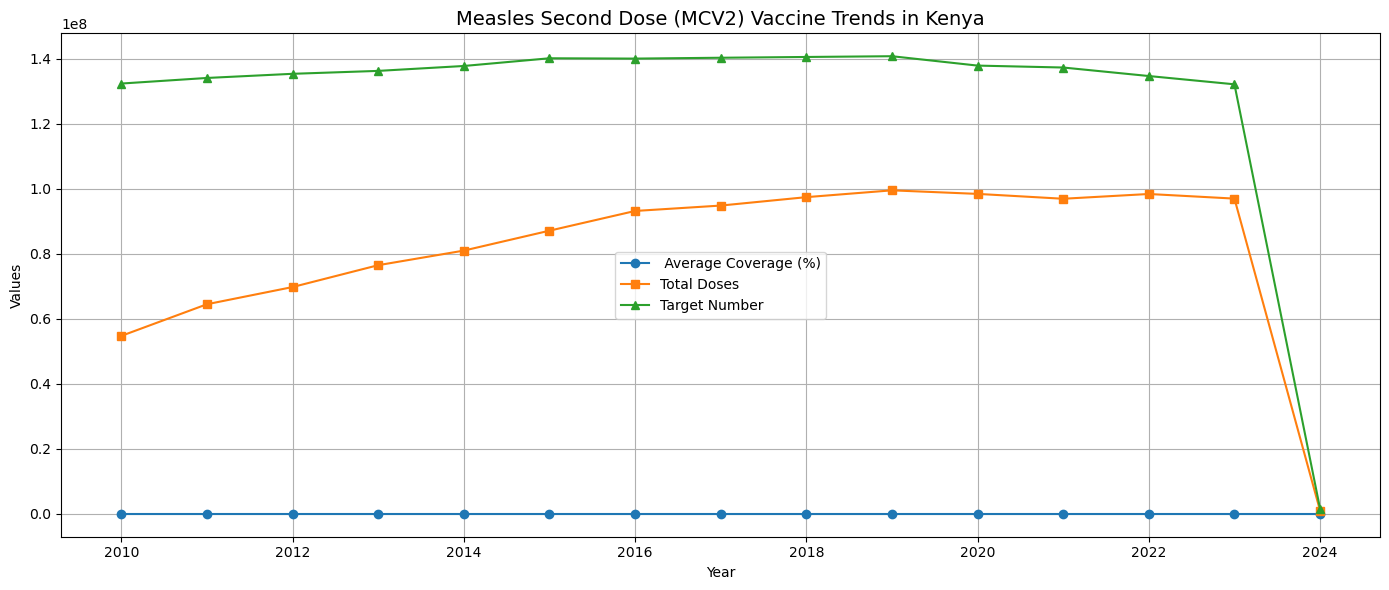

In [39]:
import matplotlib.pyplot as plt

# Group and summarize
mv2_grouped = mv2_df.groupby("YEAR").agg({
    "COVERAGE": "mean",
    "DOSES": "sum",
    "TARGET_NUMBER": "sum"
}).reset_index()

# Plot the trends
plt.figure(figsize=(14, 6))
plt.plot(mv2_grouped["YEAR"], mv2_grouped["COVERAGE"], marker='o', label=' Average Coverage (%)')
plt.plot(mv2_grouped["YEAR"], mv2_grouped["DOSES"], marker='s', label='Total Doses')
plt.plot(mv2_grouped["YEAR"], mv2_grouped["TARGET_NUMBER"], marker='^', label='Target Number')

plt.title("Measles Second Dose (MCV2) Vaccine Trends in Kenya", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Values")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


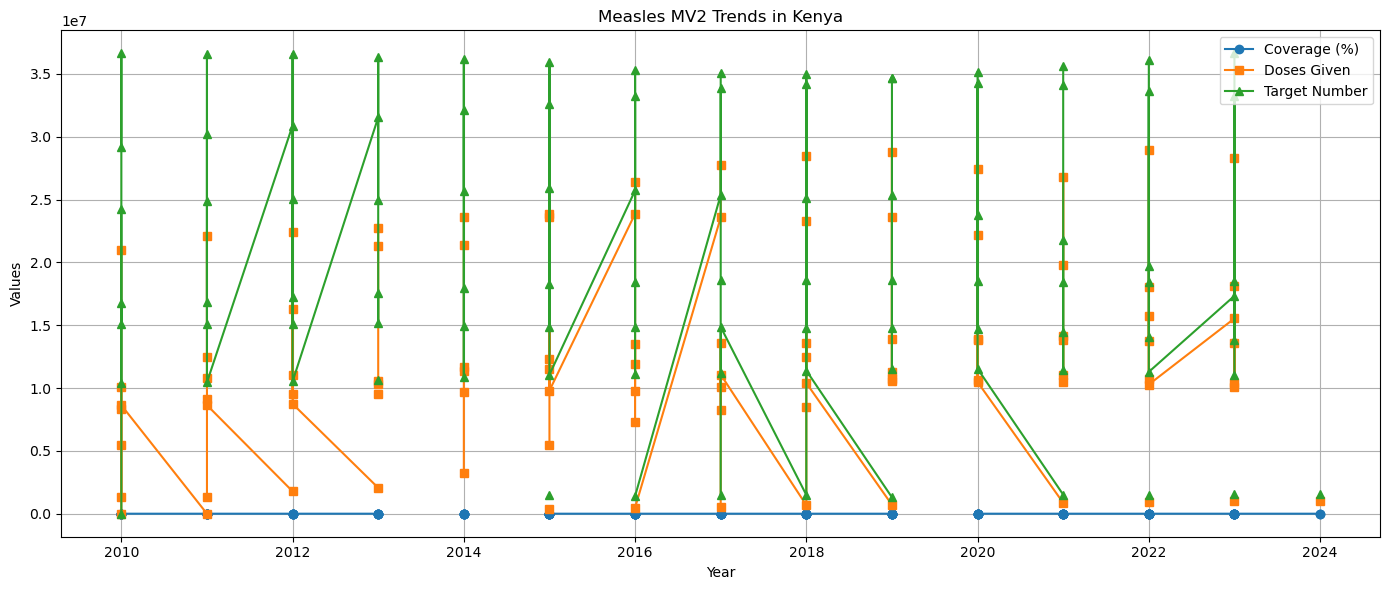

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(mv2_df["YEAR"], mv2_df["COVERAGE"], marker="o", label="Coverage (%)")
plt.plot(mv2_df["YEAR"], mv2_df["DOSES"], marker="s", label="Doses Given")
plt.plot(mv2_df["YEAR"], mv2_df["TARGET_NUMBER"], marker="^", label="Target Number")

plt.title("Measles MV2 Trends in Kenya")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# ✅ Step 2: Model Selection and Training (MV2 Data)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Reload the MV2 data if not already loaded
mv2_file = 'polio-measles-prediction/Measles vaccination coverage 2025-12-06 10-59 UTC (MV 2).xlsx'
mv2_df = pd.read_excel(mv2_file)

# Filter relevant rows (optional if already filtered)
mv2_df = mv2_df[mv2_df['ANTIGEN'] == 'MCV2']

# Drop rows with missing target values
mv2_clean = mv2_df.dropna(subset=['YEAR', 'DOSES', 'TARGET_NUMBER', 'COVERAGE'])

# Define features (X) and target (y)
X = mv2_clean[['YEAR', 'DOSES', 'TARGET_NUMBER']]
y = mv2_clean['COVERAGE']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Mean Squared Error (MSE): {mse:.2f}")
print(f"📈 R-squared Score: {r2:.2f}")

# Visualize actual vs predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Coverage")
plt.ylabel("Predicted Coverage")
plt.title("MV2 Coverage Prediction: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()
